# BIG CAT CLASSIFICATION 🦁 🐯 

>This project involves preparing and preprocessing image data, followed by applying three different approaches to image classification for the Big Cat image set. These approaches include using pre-trained VGG16 and ResNet-152 models as a starting point, fine-tuning their respective layers for classification tasks, as well as training a custom CNN architecture from scratch.

>The models are evaluated based on their performance using a test dataset provided by [Kaggle](https://www.kaggle.com/datasets/gpiosenka/cats-in-the-wild-image-classification), and their test accuracies are compared against each other. Furthermore, the optimizer and loss function used for each model are kept the same to ensure a fair comparison between the architectures. However, the hyperparameters are adjusted separately for each model to produce the best results.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Files From Kaggle

In [ ]:
!pip install kaggle
!chmod 600 /content/drive/MyDrive/kaggle/kaggle.json
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'
!kaggle datasets download -d gpiosenka/cats-in-the-wild-image-classification --unzip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 98% 121M/123M [00:06<00:00, 25.1MB/s]
100% 123M/123M [00:06<00:00, 20.4MB/s]


## Establish Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
from collections import Counter
import torch.optim.lr_scheduler as lr_scheduler

## Load Data
>I have defined a normalize transformation using the mean and standard deviation values provided for the VGG16 dataset. I have included this transformation in the transform pipeline used for loading the images. I used the ImageFolder function to load the images and their labels, and the DataLoader function to create the dataloaders for the train, validation, and test sets.

In [ ]:
img_size = 224
batch_size = 32

# Define image transformations
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    normalize
])

# Define datasets
train_set = ImageFolder('/content/train', transform=transform)
val_set = ImageFolder('/content/valid', transform=transform)
test_set = ImageFolder('/content/test', transform=transform)

# Get number of images in each folder
train_counter = Counter(train_set.targets)
val_counter = Counter(val_set.targets)
test_counter = Counter(test_set.targets)

# Get number of subfolders
train_subfolders = len(train_set.classes)
val_subfolders = len(val_set.classes)
test_subfolders = len(test_set.classes)

# Define dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Print results
print(f'Train set: {sum(train_counter.values())} images belonging to {train_subfolders} classes')
print(f'Val set: {sum(val_counter.values())} images belonging to {val_subfolders} classes')
print(f'Test set: {sum(test_counter.values())} images belonging to {test_subfolders} classes')


Train set: 2339 images belonging to 10 classes
Val set: 50 images belonging to 10 classes
Test set: 50 images belonging to 10 classes


#VGG16 Model

## Load the VGG16 model in PyTorch and Train
>This code loads a pre-trained VGG16 model and replaces its last fully-connected layer with a new one that has 10 output neurons to classify images into 10 different categories. It then trains the model for 12 epochs using a SGD optimizer with a learning rate of 0.0001, momentum of 0.4, and weight decay of 0.003. The training and test data are loaded using the Big Cat Classification data set and moved to the GPU if available. During training, the model calculates the loss and updates the weights using backpropagation. After each epoch, the model is evaluated on the test set to calculate the test accuracy. The training and test accuracies are then plotted to visualize the performance of the model.


In [ ]:
num_classes = 10

# Load pre-trained VGG16 model
vgg16_model = models.vgg16(weights='DEFAULT')

# Replace the last fully-connected layer with a new one that matches the number of classes
in_features = vgg16_model.classifier[-1].in_features
vgg16_model.classifier[-1] = nn.Linear(in_features, num_classes)

# Move model and data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16_model = vgg16_model.to(device)

# Define optimizer and learning rate
# Define loss function
optimizer = optim.SGD(vgg16_model.parameters(), lr=0.0001, momentum=0.4, weight_decay=0.003)
criterion = nn.CrossEntropyLoss()

# Define lists to store training and test accuracies
train_accs, val_accs, test_accs = [], [], []

# Train and test the model
num_epochs = 12
for epoch in range(num_epochs):
    # Train the model
    vgg16_model.train()
    train_loss, train_correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_correct += torch.sum(torch.max(outputs, 1)[1] == labels.data)
    train_loss /= len(train_set)
    train_acc = train_correct.double() / len(train_set)
    train_accs.append(train_acc)

    # Evaluate the model on validation set
    vgg16_model.eval()
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16_model(inputs)
            val_correct += torch.sum(torch.max(outputs, 1)[1] == labels.data)
    val_acc = val_correct.double() / len(val_set)
    val_accs.append(val_acc)

    # Evaluate the model on test set
    test_loss, test_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            test_correct += torch.sum(torch.max(outputs, 1)[1] == labels.data)
    test_loss /= len(test_set)
    test_acc = test_correct.double() / len(test_set)
    test_accs.append(test_acc)
    
    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {100*train_acc:.2f}%, Val Acc: {100*val_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {100*test_acc:.2f}%")

Epoch [1/12], Train Loss: 2.1478, Train Acc: 22.02%, Val Acc: 64.00%, Test Loss: 1.6922, Test Acc: 68.00%
Epoch [2/12], Train Loss: 1.5521, Train Acc: 52.29%, Val Acc: 80.00%, Test Loss: 1.0869, Test Acc: 84.00%
Epoch [3/12], Train Loss: 1.0583, Train Acc: 69.60%, Val Acc: 90.00%, Test Loss: 0.6456, Test Acc: 90.00%
Epoch [4/12], Train Loss: 0.7403, Train Acc: 77.30%, Val Acc: 86.00%, Test Loss: 0.4172, Test Acc: 92.00%
Epoch [5/12], Train Loss: 0.5971, Train Acc: 81.02%, Val Acc: 90.00%, Test Loss: 0.3040, Test Acc: 90.00%
Epoch [6/12], Train Loss: 0.5236, Train Acc: 82.94%, Val Acc: 90.00%, Test Loss: 0.2570, Test Acc: 92.00%
Epoch [7/12], Train Loss: 0.4654, Train Acc: 84.91%, Val Acc: 92.00%, Test Loss: 0.2437, Test Acc: 94.00%
Epoch [8/12], Train Loss: 0.4302, Train Acc: 86.32%, Val Acc: 94.00%, Test Loss: 0.1854, Test Acc: 98.00%
Epoch [9/12], Train Loss: 0.3716, Train Acc: 88.37%, Val Acc: 92.00%, Test Loss: 0.1840, Test Acc: 94.00%
Epoch [10/12], Train Loss: 0.3613, Train Acc: 

###Plot the training accuracy vs. test accuracy over each epoch.

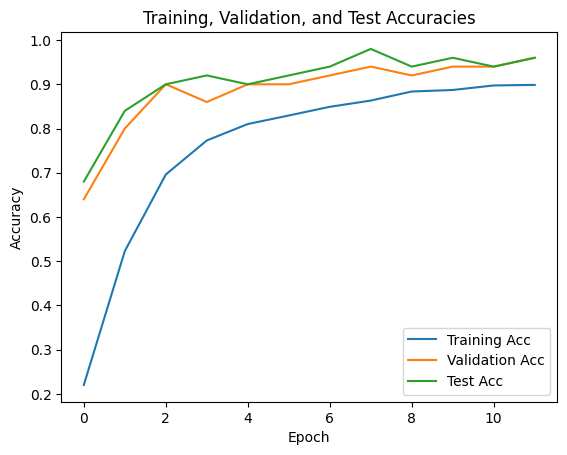

In [ ]:
# Convert accuracy lists to NumPy arrays
train_accs = np.array([t.cpu().numpy() for t in train_accs])
val_accs = np.array([t.cpu().numpy() for t in val_accs])
test_accs = np.array([t.cpu().numpy() for t in test_accs])

# Create epochs array
epochs = np.arange(num_epochs)

# Plot accuracies
plt.plot(epochs, train_accs, label='Training Acc')
plt.plot(epochs, val_accs, label='Validation Acc')
plt.plot(epochs, test_accs, label='Test Acc')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracies')
plt.legend()

# Show plot
plt.show()

#ResNet-152 Model

## Load the ResNet-152 model in PyTorch and Train

In [ ]:
# Load pre-trained ResNet152
resnet_model = models.resnet152(weights='DEFAULT')

# Modify the last fully connected layer for our specific task
num_classes = len(train_set.classes)
in_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.0015, momentum=0.35, weight_decay=0.0025)

# Move model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)

train_accuracies = []
val_accuracies = []
test_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    # Train the model
    resnet_model.train()
    train_loss = 0
    train_correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        total += labels.size(0)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_acc = 100 * train_correct / total
    train_loss /= len(train_loader.dataset)

    # Evaluate the model on validation set
    resnet_model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = resnet_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total

    # Test the model
    resnet_model.eval()
    test_loss = 0
    test_correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            total += labels.size(0)
            test_loss += loss.item() * inputs.size(0)

    test_acc = 100 * test_correct / total
    test_loss /= len(test_loader.dataset)

     # Store values
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    # Print 
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


Epoch [1/10], Train Loss: 2.1753, Train Acc: 32.32%, Val Acc: 58.00%, Test Loss: 1.9983, Test Acc: 66.00%
Epoch [2/10], Train Loss: 1.8640, Train Acc: 70.88%, Val Acc: 76.00%, Test Loss: 1.6501, Test Acc: 86.00%
Epoch [3/10], Train Loss: 1.5309, Train Acc: 79.91%, Val Acc: 84.00%, Test Loss: 1.3146, Test Acc: 90.00%
Epoch [4/10], Train Loss: 1.1850, Train Acc: 84.44%, Val Acc: 88.00%, Test Loss: 1.0004, Test Acc: 92.00%
Epoch [5/10], Train Loss: 0.9047, Train Acc: 87.35%, Val Acc: 94.00%, Test Loss: 0.7057, Test Acc: 90.00%
Epoch [6/10], Train Loss: 0.6891, Train Acc: 89.74%, Val Acc: 94.00%, Test Loss: 0.5507, Test Acc: 92.00%
Epoch [7/10], Train Loss: 0.5451, Train Acc: 90.55%, Val Acc: 96.00%, Test Loss: 0.4350, Test Acc: 92.00%
Epoch [8/10], Train Loss: 0.4594, Train Acc: 91.75%, Val Acc: 98.00%, Test Loss: 0.3388, Test Acc: 94.00%
Epoch [9/10], Train Loss: 0.3899, Train Acc: 92.77%, Val Acc: 98.00%, Test Loss: 0.2725, Test Acc: 96.00%
Epoch [10/10], Train Loss: 0.3373, Train Acc: 

###Plot the train accuracy vs test accuracy over each epoch.

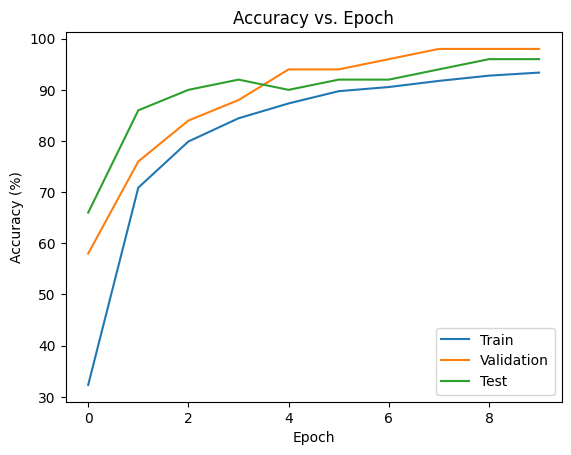

In [ ]:
# Plot accuracies
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.plot(test_accuracies, label='Test')

# Set title and labels
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

# Set legend
plt.legend()

# Show plot
plt.show()

# My Own Custom CNN

## Define my CNN
>MyCNN class inherits from the nn.Module class in PyTorch, which means that it can be trained and optimized using PyTorch's autograd functionality.
The architecture of the network consists of several layers of convolutional, batch normalization, SiLU activation, and max-pooling layers. The convolutional layers learn different features from the input images, while the max-pooling layers reduce the spatial dimension of the feature maps.
The nn.AdaptiveAvgPool2d layer is used to convert the final feature maps into a fixed-size representation, which can be used by the fully connected classifier layer to make the final prediction.
The classifier layer is a sequence of fully connected layers with SiLU activation and dropout regularization. The number of nodes in the output layer is equal to the number of classes in the dataset, which is specified as an input argument to the MyCNN constructor.
The forward method of the MyCNN class takes an input tensor x of shape (batch_size, num_channels, height, width) and passes it through the layers of the network in sequence. The final output is a tensor of shape (batch_size, num_classes), where each element represents the predicted probability of the corresponding class.

>Overall, MyCNN class has 28 layers (excluding the Dropout layer and the final output layer), which consist of 12 convolutional layers, 6 batch normalization layers, 6 SiLU activation functions, 6 max-pooling layers, and 3 fully connected layers.

In [ ]:
class MyCNN(nn.Module):
    def __init__(self, num_classes):
        super(MyCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.SiLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.SiLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.SiLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.SiLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.SiLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.SiLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout()
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.SiLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.SiLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Train and Test MyCNN

In [ ]:
num_classes = 10

# Define MyCNN model
my_cnn = MyCNN(num_classes=num_classes)

# Move model and data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_cnn = my_cnn.to(device)

# Define optimizer and learning rate, loss function, and lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_cnn.parameters(), lr=0.003, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Define lists to store training, validation, and test accuracies
train_accs, val_accs, test_accs = [], [], []

# Train and test the model
num_epochs = 25
for epoch in range(num_epochs):
    # Shuffle the training data
    train_loader.shuffle = True
    
    # Train the model
    my_cnn.train()
    train_loss, train_correct = 0.0, 0
    iteration = 0;
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = my_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_correct += torch.sum(torch.max(outputs, 1)[1] == labels.data)
    train_loss /= len(train_set)
    train_acc = train_correct.double() / len(train_set)
    train_accs.append(train_acc)

    # Validate the model
    my_cnn.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = my_cnn(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_correct += torch.sum(torch.max(outputs, 1)[1] == labels.data)
    val_loss /= len(val_set)
    val_acc = val_correct.double() / len(val_set)
    val_accs.append(val_acc)

    # Update lr scheduler based on validation accuracy
    scheduler.step(val_acc)

    # Test the model
    my_cnn.eval()
    test_loss, test_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = my_cnn(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            test_correct += torch.sum(torch.max(outputs, 1)[1] == labels.data)
    test_loss /= len(test_set)
    test_acc = test_correct.double() / len(test_set)
    test_accs.append(test_acc)

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {100*train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {100*val_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {100*test_acc:.2f}%")


Epoch [1/25], Train Loss: 2.1346, Train Acc: 19.97%, Val Loss: 1.8723, Val Acc: 30.00%, Test Loss: 1.9168, Test Acc: 28.00%
Epoch [2/25], Train Loss: 1.6843, Train Acc: 33.13%, Val Loss: 1.4133, Val Acc: 46.00%, Test Loss: 1.5723, Test Acc: 38.00%
Epoch [3/25], Train Loss: 1.4783, Train Acc: 39.85%, Val Loss: 1.2469, Val Acc: 52.00%, Test Loss: 1.2791, Test Acc: 46.00%
Epoch [4/25], Train Loss: 1.3101, Train Acc: 47.67%, Val Loss: 1.6465, Val Acc: 44.00%, Test Loss: 1.6321, Test Acc: 46.00%
Epoch [5/25], Train Loss: 1.1995, Train Acc: 53.27%, Val Loss: 1.2225, Val Acc: 44.00%, Test Loss: 1.1428, Test Acc: 54.00%
Epoch [6/25], Train Loss: 1.1121, Train Acc: 55.71%, Val Loss: 1.1930, Val Acc: 50.00%, Test Loss: 1.0439, Test Acc: 60.00%
Epoch 00007: reducing learning rate of group 0 to 3.0000e-04.
Epoch [7/25], Train Loss: 0.9982, Train Acc: 61.99%, Val Loss: 2.9941, Val Acc: 32.00%, Test Loss: 2.9610, Test Acc: 32.00%
Epoch [8/25], Train Loss: 0.8845, Train Acc: 65.84%, Val Loss: 0.8473,

###Plot the train, validation, and test accuracy over each epoch.

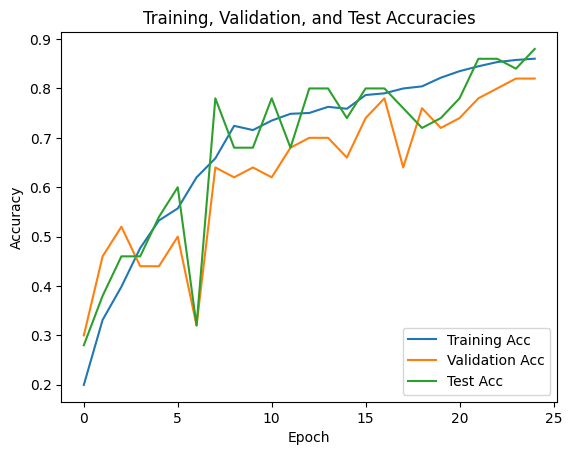

In [ ]:
# Convert accuracy lists to NumPy arrays
train_accs = np.array([t.cpu().numpy() for t in train_accs])
val_accs = np.array([t.cpu().numpy() for t in val_accs])
test_accs = np.array([t.cpu().numpy() for t in test_accs])

# Create epochs array
epochs = np.arange(num_epochs)

# Plot accuracies
plt.plot(epochs, train_accs, label='Training Acc')
plt.plot(epochs, val_accs, label='Validation Acc')
plt.plot(epochs, test_accs, label='Test Acc')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracies')
plt.legend()

# Show plot
plt.show()

## **Final Test:** VGG16 vs. ResNet152 vs. MyCNN


> I trained three deep learning models, VGG16, ResNet152, and MyCNN, and will compare their test accuracies on the same test set. 

> To ensure a fair comparison among models, I trained all of them on the same training and validation datasets. Additionally, to optimize the models' parameters, I used the same optimizer, torch.optim.SGD, for all of them. To measure the accuracy of the models, I utilized torch Cross-Entropy Loss function. By using consistent training and evaluation methodologies, I aimed to eliminate any potential bias.



### Augment the test set from earlier to create a new test set

In [ ]:
from torchvision.transforms import RandomRotation, RandomHorizontalFlip

# Define new test set transform with data augmentation
new_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

# Apply new transform to original test set
new_test_set = ImageFolder('/content/test', transform=new_transform)

# Define new test loader
new_test_loader = DataLoader(new_test_set, batch_size=batch_size, shuffle=False)

# Print results
print(f'Original Test set: {sum(test_counter.values())} images belonging to {test_subfolders} classes')
print(f'New Test set: {sum(Counter(new_test_set.targets).values())} images belonging to {len(new_test_set.classes)} classes')

Original Test set: 50 images belonging to 10 classes
New Test set: 50 images belonging to 10 classes


### Initialize all three models, to be tested against the new test set. 

In [ ]:
from torchvision import models
from torch import optim
num_classes = 10

# Load pre-trained VGG16 model
vgg16_model = models.vgg16(weights='DEFAULT')
# Replace the last fully-connected layer with a new one that matches the number of classes
in_features = vgg16_model.classifier[-1].in_features
vgg16_model.classifier[-1] = nn.Linear(in_features, num_classes)
# Move model and data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16_model = vgg16_model.to(device)


# Load pre-trained ResNet152
resnet_model = models.resnet152(weights='DEFAULT')
# Modify the last fully connected layer for our specific task
num_classes = len(train_set.classes)
in_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_features, num_classes)
resnet_model = resnet_model.to(device)

# define the criterion
criterion = nn.CrossEntropyLoss()

# define the optimizers
vgg16_optimizer = optim.SGD(vgg16_model.parameters(), lr=0.0001, momentum=0.4, weight_decay=0.003)
resnet152_optimizer = optim.SGD(resnet_model.parameters(), lr=0.0015, momentum=0.35, weight_decay=0.0025)

### Define the test function and run test for each model


> Re-train the vgg16 and resnet models the exact same as before (because state of notebook is not saved in Google colab.) My CNN state is still current at this point, no need to re-train.



In [ ]:
def train(model, train_loader, optimizer, criterion):
    model.train() # Set the model to training mode
    running_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # Zero out the gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward() # Compute gradients
        optimizer.step() # Update weights
        running_loss += loss.item()
    return running_loss / len(train_loader)

def test(model, test_loader):
    model.eval() # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

models = {'vgg16': vgg16_model, 'resnet152': resnet_model, 'my_cnn': my_cnn}
optimizers = {'vgg16': vgg16_optimizer, 'resnet152': resnet152_optimizer}
criterion = nn.CrossEntropyLoss()

train_loaders = {'vgg16': train_loader, 'resnet152': train_loader, 'my_cnn': None}
test_loaders = {'vgg16': test_loader, 'resnet152': test_loader, 'my_cnn': test_loader}

num_epochs = 10
train_losses = {'vgg16': [], 'resnet152': [], 'my_cnn': []}
test_accuracies = {'vgg16': [], 'resnet152': [], 'my_cnn': []}

for model_name, model in models.items():
  if train_loaders[model_name] is not None:
    optimizer = optimizers[model_name]
    criterion = nn.CrossEntropyLoss()
    train_losses[model_name] = []
    test_accuracies[model_name] = []
    for epoch in range(num_epochs):
        train_loader = train_loaders[model_name]
        train_loss = train(model, train_loader, optimizer, criterion)
        train_losses[model_name].append(train_loss)
        accuracy = test(model, test_loaders[model_name])
        test_accuracies[model_name].append(accuracy)
        print(f"Model: {model_name}, Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Test Accuracy: {accuracy:.2f}")
  else:
    accuracy = test(model, test_loaders[model_name])
    test_accuracies[model_name].append(accuracy)
    print(f"Model: {model_name}, Epoch: {epoch+1}, Test Accuracy: {accuracy:.2f}")

Model: vgg16, Epoch: 1, Train Loss: 2.1620, Test Accuracy: 68.00
Model: vgg16, Epoch: 2, Train Loss: 1.5885, Test Accuracy: 86.00
Model: vgg16, Epoch: 3, Train Loss: 1.0962, Test Accuracy: 90.00
Model: vgg16, Epoch: 4, Train Loss: 0.7843, Test Accuracy: 94.00
Model: vgg16, Epoch: 5, Train Loss: 0.6257, Test Accuracy: 92.00
Model: vgg16, Epoch: 6, Train Loss: 0.5038, Test Accuracy: 94.00
Model: vgg16, Epoch: 7, Train Loss: 0.4652, Test Accuracy: 94.00
Model: vgg16, Epoch: 8, Train Loss: 0.4187, Test Accuracy: 94.00
Model: vgg16, Epoch: 9, Train Loss: 0.3762, Test Accuracy: 94.00
Model: vgg16, Epoch: 10, Train Loss: 0.3545, Test Accuracy: 96.00
Model: resnet152, Epoch: 1, Train Loss: 2.1521, Test Accuracy: 56.00
Model: resnet152, Epoch: 2, Train Loss: 1.8491, Test Accuracy: 84.00
Model: resnet152, Epoch: 3, Train Loss: 1.5038, Test Accuracy: 86.00
Model: resnet152, Epoch: 4, Train Loss: 1.1658, Test Accuracy: 88.00
Model: resnet152, Epoch: 5, Train Loss: 0.8902, Test Accuracy: 92.00
Mode

Plot the test accuracies of each model

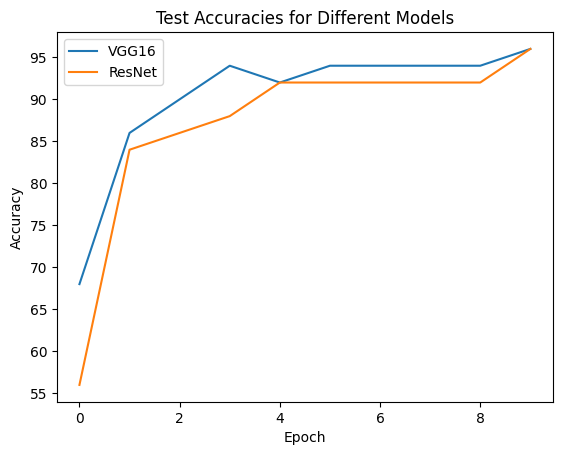

In [ ]:
# Extract the test accuracies for each model
vgg16_acc = test_accuracies['vgg16']
resnet_acc = test_accuracies['resnet152']
my_cnn_acc = test_accuracies['my_cnn']

# Plot the test accuracies for each model
plt.plot(vgg16_acc, label='VGG16')
plt.plot(resnet_acc, label='ResNet')

plt.title('Test Accuracies for Different Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Bar Graph Representation

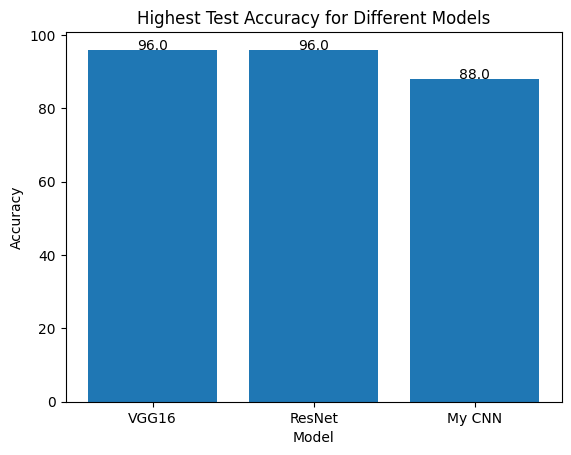

In [ ]:
# Find the maximum test accuracy achieved by each model
vgg16_max_acc = max(vgg16_acc)
resnet_max_acc = max(resnet_acc)
my_cnn_max_acc = max(my_cnn_acc)

# Create a bar graph showing the highest accuracy for each model
models = ['VGG16', 'ResNet', 'My CNN']
max_accs = [vgg16_max_acc, resnet_max_acc, my_cnn_max_acc]
plt.bar(models, max_accs)
plt.title('Highest Test Accuracy for Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Add text labels to the bars
for i, v in enumerate(max_accs):
    plt.text(i, v, str(round(v, 2)), color='black', ha='center')

plt.show()